In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src import *
from ipywidgets import interact, widgets

In [30]:
model, config = load_model_locally('001_mel/0', 'rvce')

In [31]:
files = config.training_files
datapool = DataPool(files, config)

Video loading:   0%|          | 0/14 [00:00<?, ?it/s]

In [33]:
config_1 = EasyDict(config)
config_2 = EasyDict(config)

config_1.sr = config_2.sr = 22050

config_2.transformation = 'stft'
# config_1.transformation = config_2.transformation = 'mel'
config_1.n_mels = 64


In [35]:
transform_1 = create_transformation(config_1)
transform_2 = create_transformation(config_2)

file_number = 2
signal = datapool[files[file_number]].signal.clone()

def f(from_time=0):
    till_time = from_time + 10
    
    from_sample = from_time * config.sr
    till_sample = till_time * config.sr
    
    signal_1 = signal[from_sample: till_sample].clone()
    features_1 = transform_1(signal_1).squeeze()

    signal_2 = signal[from_sample: till_sample].clone()
    features_2 = transform_2(signal_2).squeeze()
        
    vmin = min(features_1.min(), features_2.min())
    vmax = max(features_1.max(), features_2.max())
    
    fig, axes = plt.subplots(ncols=2, figsize=(15,5))
    ax1, ax2 = axes.flatten()

    # blur = torchvision.transforms.GaussianBlur(5)
    print(features_1.shape, features_2.shape)
    # features_2 = blur(features_2.unsqueeze(0)).squeeze()
    # print(features_2.shape)
        
    im1 = ax1.pcolormesh(features_1, vmin=vmin, vmax=vmax)
    im2 = ax2.pcolormesh(features_2, vmin=vmin, vmax=vmax)

    plt.tight_layout()
    fig.colorbar(im2, ax=[ax1, ax2])
    plt.show()

from_time_slider = widgets.IntSlider(min=0, max=60*20, step=1, value=260)
interact(f, from_time=from_time_slider);

interactive(children=(IntSlider(value=260, description='from_time', max=1200), Output()), _dom_classes=('widge…

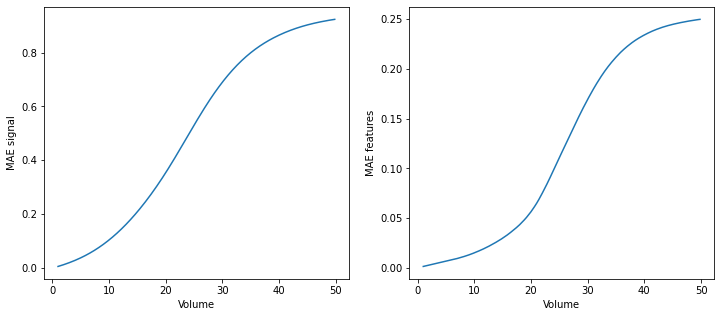

In [167]:
transform = create_transformation(config)

from_time = 280
till_time = from_time + 6

from_sample = from_time * config.sr
till_sample = till_time * config.sr

file_number = 0
signal = datapool[files[file_number]].signal

signal_1 = signal[from_sample: till_sample].clone()
features_1 = transform(signal_1).squeeze()

signal_maes = []
feature_maes = []
volumes = np.arange(1, 50, .2)

for volume in volumes:
    volume_transform = torchaudio.transforms.Vol(volume, 'db')

    signal_2 = signal[from_sample: till_sample].clone()
    signal_2 = volume_transform(signal_2)
    features_2 = transform(signal_2).squeeze()
    
    signal_mae = (signal_1 - signal_2).abs().mean().item()
    feature_mae = (features_1 - features_2).abs().mean().item()
    

    signal_maes.append(signal_mae)
    feature_maes.append(feature_mae)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].set_xlabel('Volume')
axes[0].set_ylabel('MAE signal')

axes[1].set_xlabel('Volume')
axes[1].set_ylabel('MAE features')
axes[0].plot(volumes, signal_maes);
axes[1].plot(volumes, feature_maes);

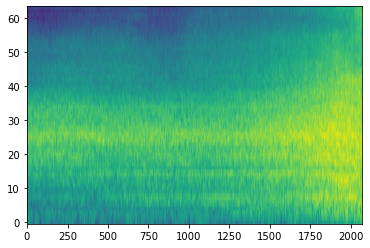

In [16]:
plt.imshow(features_1, aspect='auto')
plt.gca().invert_yaxis()

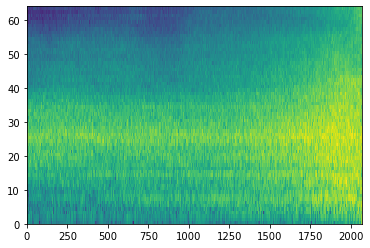

In [17]:
plt.pcolormesh(features_1);

In [18]:
transform_1 = create_transformation(config_1)
transform_2 = create_transformation(config_2)

### Compare global (across video) and local (across window) normalization

In [35]:
model, config = load_model_locally('one_location_gaussian_blur', 'rvce')
files = ['12_RX100']
datapool = DataPool(files, config.window_length, config.split_ratio, tqdm=tqdm)
transform = create_transformation(config)
signal = datapool[files[file_number]].signal.clone()

Video loading:   0%|          | 0/1 [00:00<?, ?it/s]

In [92]:
features_long = transform(signal).squeeze()

def find_windows(i):
    features_from = int(i * config.n_features_in_nn_hop)
    features_till = int(features_from + config.n_features_in_window)

    features_long_window = features_long[:, features_from:features_till]

    from_sample = int(i * config.n_samples_in_nn_hop)
    till_sample = int(from_sample + config.n_samples_in_window)

    signal_short = signal[from_sample: till_sample]

    features_short_window = transform(signal_short).squeeze()

    return features_long_window, features_short_window

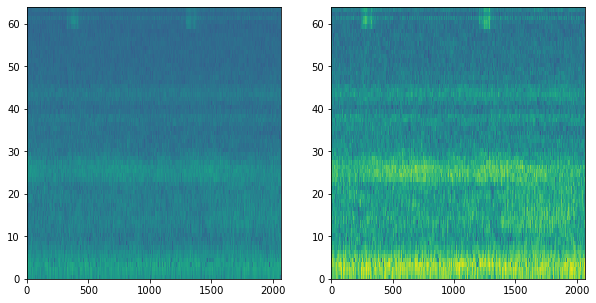

In [84]:
# features_long_window, features_short_window = find_windows(22)
features_long_window, features_short_window = find_windows(27)

fig, axes = plt.subplots(1, 2, figsize=(10,5))

vmin = min(features_long_window.min(), features_short_window.min())
vmax = max(features_long_window.max(), features_short_window.max())

axes[0].pcolormesh(features_long_window, vmin=vmin, vmax=vmax)
axes[1].pcolormesh(features_short_window, vmin=vmin, vmax=vmax)

In [96]:
vmin = features_long.min()
vmax = features_long.max()

def g(i=0):
    features_long_window, features_short_window = find_windows(i)

    fig, axes = plt.subplots(1, 2, figsize=(10,5))

    axes[0].pcolormesh(features_long_window, vmin=vmin, vmax=vmax)
    axes[1].pcolormesh(features_short_window, vmin=vmin, vmax=vmax)
    plt.show()

# i = widgets.IntSlider(min=0, max=100, step=1, value=0)
i = widgets.FloatSlider(min=0, max=100, step=.2, value=0)
interact(g, i=i);

interactive(children=(FloatSlider(value=0.0, description='i', step=0.2), Output()), _dom_classes=('widget-inte…

In [ ]:
35.60,